In [80]:
# 캐글 신용카드 사기 검출 

# 주의사항 . 깃 이그노어에 크레딧카드.csv  꼭 올라가지 않도록..

(lightGBM설치)  

conda activate base  
conda install -c conda-forge lightgbm

(SMOTE) Oversampling은 하지 마세용

In [81]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
import warnings
warnings.filterwarnings("ignore")

card_df = pd.read_csv('creditcard.csv')

In [82]:
card_df

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0


In [83]:
from sklearn.model_selection import train_test_split

def get_preprocessed_df(df=None):
    df_copy = df.copy()
    df_copy.drop('Time', axis = 1, inplace=True)
    return df_copy

In [84]:
# 사전 데이터 가공 후 학습과 테스트 데이터 세트를 반환하는 함수. 
def get_train_test_dataset(df=None):
    # 인자로 입력된 DataFrame의 사전 데이터 가공이 완료된 복사 DataFrame 반환
    df_copy = get_preprocessed_df(df)
    X_features = df_copy.iloc[:, :-1]
    y_target = df_copy.iloc[:, -1]
    
    X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.3, random_state=0, stratify=y_target)
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

In [85]:
print(y_train.value_counts()/y_train.shape[0]*100)   # y_train.shape[0] 행의 개수를 뽑을때 
print(y_test.value_counts()/y_test.shape[0]*100)

0    99.827451
1     0.172549
Name: Class, dtype: float64
0    99.826785
1     0.173215
Name: Class, dtype: float64


In [86]:
# 로지스틱 회귀 및 lightGBM 모델 예측 성능을 데이터 가공 수행하면서 변화과정 측정

In [87]:
# 먼저 로지스틱 회귀
from sklearn.linear_model import LogisticRegression

lr_clf = LogisticRegression()
lr_clf.fit(X_train, y_train)
lr_pred = lr_clf.predict(X_test)
lr_pred_proba = lr_clf.predict_proba(X_test)[:, 1] #1열만? 

In [88]:
# 3장 친구 이런거 계속 쌓아가야 하나?
# 수정된 get_clf_eval() 함수 
def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    # ROC-AUC 추가 
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('오차 행렬')
    print(confusion)
    # ROC-AUC print 추가
    print(f'정확도: {accuracy:.4f}, 정밀도: {precision:.4f}, 재현율: {recall:.4f}, ', end='')
    print(f'F1: {f1:.4f}, AUC: {roc_auc:.4f}')

# 싹다 임포트

In [89]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import f1_score, confusion_matrix, precision_recall_curve, roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

In [90]:
get_clf_eval(y_test, lr_pred, lr_pred_proba)

오차 행렬
[[85280    15]
 [   62    86]]
정확도: 0.9991, 정밀도: 0.8515, 재현율: 0.5811, F1: 0.6908, AUC: 0.9554


In [91]:
# 인자로 사이킷런의 Estimator 객체와 학습 / 테스트 데이터 세트를 입력 받아서 학습/예측/평가 수행.

def get_model_train_eval(model, ftr_train=None, ftr_test=None, tgt_train=None, tgt_test=None):
    model.fit(ftr_train, tgt_train)
    pred = model.predict(ftr_test)
    pred_proba = model.predict_proba(ftr_test)[:, 1]
    get_clf_eval(tgt_test, pred, pred_proba)

In [92]:
from lightgbm import LGBMClassifier 

lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False)
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

오차 행렬
[[85290     5]
 [   36   112]]
정확도: 0.9995, 정밀도: 0.9573, 재현율: 0.7568, F1: 0.8453, AUC: 0.9790


데이터 분포도 변환 후 모델 학습 / 예측 / 평가

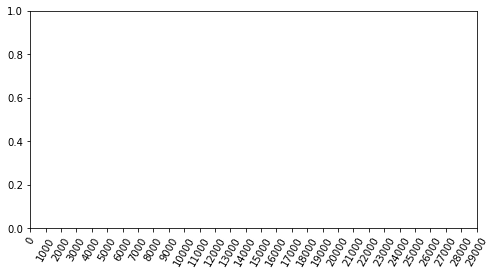

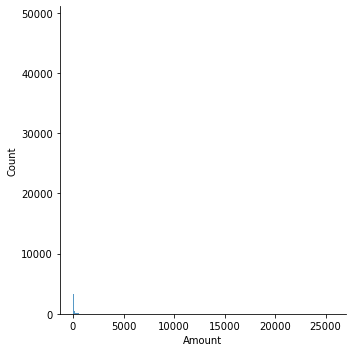

In [93]:
# 로지스틱 회귀는 선형 모델, 대부분의 선형 모델은 중요 피쳐들의 값이 정규분포 형태를 유지하는 것을 선호함
# 이부분 그래프가 책대로 안나옵니다..
import seaborn as sns
plt.figure(figsize=(8,4))
plt.xticks(range(0, 30000, 1000), rotation=60)
sns.displot(card_df['Amount'])

In [94]:
from sklearn.preprocessing import StandardScaler
# 사이킷런의 StandardScaler를 이용해 정규 분포 형태로 Amount 피처값 변환하는 로직으로 수정.
def get_preprocessed_df(df=None):
    df_copy = df.copy()
    scaler = StandardScaler()
    amount_n = scaler.fit_transform(df_copy['Amount'].values.reshape(-1,1))
    df_copy.insert(0, 'Amount_Scaled', amount_n)
    df_copy.drop(['Time', 'Amount'], axis=1, inplace=True)
    return df_copy



In [95]:
# Amount 를 정규 분포 형태로 변환 후 로지스틱 회귀 및 LightGBM 수행
X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

print("###로지스틱 회귀 예측성능 ###")
lr_clf = LogisticRegression()
get_model_train_eval(lr_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

print("### LightGBM 예측 성능###")
lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1)
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test= y_test)
# 교재랑 라이트지비엠 성능 값 다른데 , 뭔차인지 모르겠다.

###로지스틱 회귀 예측성능 ###
오차 행렬
[[85281    14]
 [   58    90]]
정확도: 0.9992, 정밀도: 0.8654, 재현율: 0.6081, F1: 0.7143, AUC: 0.9702
### LightGBM 예측 성능###
오차 행렬
[[85146   149]
 [   81    67]]
정확도: 0.9973, 정밀도: 0.3102, 재현율: 0.4527, F1: 0.3681, AUC: 0.7253


In [96]:
# 로그변환까지 한다는데, 로그변환은 데이터 분포가 심하게 왜곡되 있을때 적용하는 중요기법
# 스케일 차이가 너무나는 얘들을 로그를 이용하면 각각의 차이를 쉽게 줄일 수 있어. 차례대로 log 10, 100, 1000, 10000은 1,2,3,4처럼 바뀌기 때문
def get_preprocessed_df(df=None):
    df_copy = df.copy()
    # 넘파이의 log1p()를 이용해 Amount 를 로그 변환
    amount_n = np.log1p(df_copy['Amount'])
    df_copy.insert(0, 'Amount_Scaled', amount_n)
    df_copy.drop(['Time', 'Amount'], axis=1, inplace=True)
    return df_copy

In [97]:
X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

print('### 로지스틱 회귀 예측 성능###')
get_model_train_eval(lr_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

print('### LightGBM 예측 성능 ###')
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

### 로지스틱 회귀 예측 성능###
오차 행렬
[[85283    12]
 [   59    89]]
정확도: 0.9992, 정밀도: 0.8812, 재현율: 0.6014, F1: 0.7149, AUC: 0.9727
### LightGBM 예측 성능 ###
오차 행렬
[[85238    57]
 [   77    71]]
정확도: 0.9984, 정밀도: 0.5547, 재현율: 0.4797, F1: 0.5145, AUC: 0.7395


이상치 데이터 제거 후 모델 학습 / 예측 / 평가 (IQR, BOXPLOT시각화가능)

<AxesSubplot:>

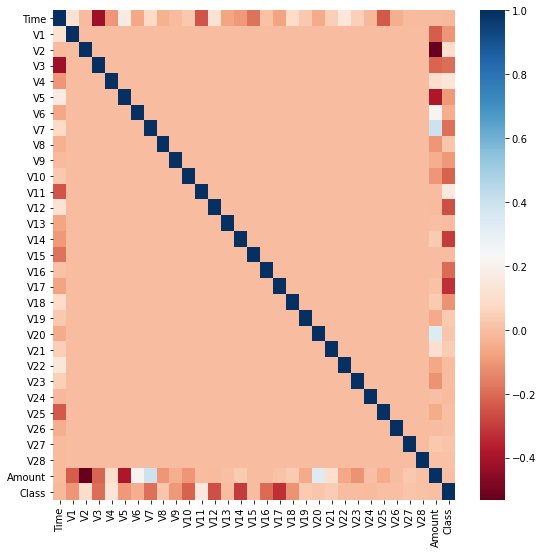

In [98]:
import seaborn as sns
plt.figure(figsize=(9,9))
corr = card_df.corr()
sns.heatmap(corr,cmap='RdBu')  # 레드다운 블루 업이란 말 같아. 블루 진할수록 양의 상관관계 레드 진할수록 음의 상관관계

In [99]:
import numpy as np

def get_outlier(df=None, column=None, weight=1.5):
    # fraud 해당하는 컬럼 데이터만 추출 q1과 q3 지점을 np.percentile 로 구현 그러나 quantile 4분위를 쓰는 게 편하다

    fraud = df[df['Class'] == 1][column]
    quantile_25 = np.quantile(fraud.values, 0.25)
    quantile_75 = np.quantile(fraud.values, 0.75)
    iqr = quantile_75 - quantile_25
    iqr_weight = iqr * weight
    lowest_val = quantile_25 - iqr_weight
    highest_val = quantile_75 + iqr_weight
    # 최댓값보다 크거나, 최솟값보다 작은 값을 이상치로 설정 및 DataFrame index 반환
    outlier_index = fraud[(fraud < lowest_val) | (fraud > highest_val)].index
    return outlier_index


In [100]:
outlier_index = get_outlier(df=card_df, column='V14', weight=1.5)
print('이상치 데이터 인덱스:', outlier_index)

이상치 데이터 인덱스: Int64Index([8296, 8615, 9035, 9252], dtype='int64')


In [101]:
# SMOTE 오버샘플링 적용 후 모델 학습 / 예측 / 평가 (미실습)

# 책내용에서 의의만 정리해 보면, 오버샘플링은 불균형한 레이블을 가지는 데이터를 증식하여 학습데이터를 늘려줌으로써 불균형을 보완해줌. 
# 로지스틱 회귀 / 라이트GBM 을 오버샘플링 버전으로 테스트 해보는데, 
# 회귀에서는 재현율은 크게 증가하나. 정밀도가 5.4% 로 급락하여 올바른 모델이 되지 못함. 

# 정밀도가 급락한 이유는 TYPE 1 error 의 증가 때문인데, 0과 1을 분류해야하는 모델에서 
# 오버샘플링을 통해 1값 (TRUE or 양성) 을 늘려서 학습했기 때문에 
# 예측상황에서도  0값을 1로 예측하는 (음성을 양성으로 판정하는 판사가 피하려하는 오류 증가, 오차행렬의 FN) 

# 반면에 라이트GBM 모델에서는 성능이 소폭 향상됐다고 볼 수 있는정도. 


# 278p 데이터 가공에 따른 성능결과 

# 데이터가공 유형              머신러닝알고리즘                평가지표(정밀도, 재현율 등)
# 원본데이터 그대로            로지~회귀 / 라이트GBM            GBM이 조금더 좋은 성능 보여
# 데이터 로그 변환                    ''                        GMB이 조곰더 좋아
# 이상치 데이터 제거                  ''                        GBM이 성능개선이 좀더 많이 됐다
# SMOTE오버샘플링                     ''                        로지~회귀 못쓰는 정도 반면GBM은 성능향상으로 볼 수 있어
